# Diabetes Clinic Assistant - Capstone Project

This notebook documents the **Diabetes Clinic Assistant** system, shows quick demos against the local API, and records troubleshooting notes for reproducibility.


**A patient- and staff-friendly web app for diabetes education and clinic support.**

This prototype provides:
1. Conversational interface with limited memory  
2. Document-based Question Answering (RAG)  
3. Text-to-image generation  
4. Multi-agent tools (Weather / SQL / Recommender)  
5. Glucose safety triage (educational only)


System Aechitecture:

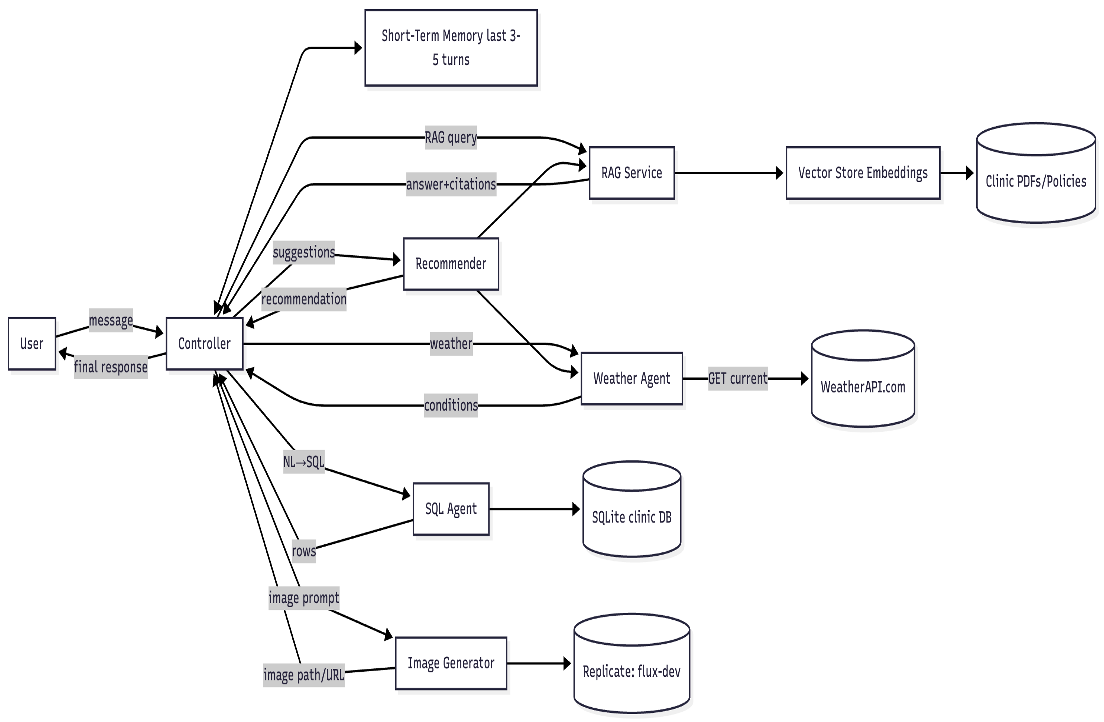

•	Frontend: HTML-based chat and upload pages (/chat.html, /upload.html, / home).

•	Backend: FastAPI service (app.py) handling all routes, chat sessions, and agents.

•	Agents (Modular Services):
1.	RAG Agent — Retrieval-Augmented Generation using ChromaDB & Sentence-Transformers.
2.	Weather Agent — Fetches live weather data from WeatherAPI.com.
3.	SQL Agent — In-memory product catalog for demo queries.
4.	Recommender Agent — Content-based recommendation using MiniLM embeddings.
5.	Text-to-Image Agent — Image generation via Replicate (black-forest-labs/flux-dev).
6.	Glucose Triage Agent — Basic interpretation of patient glucose levels (educational guidance only).
•	Memory: Each chat session maintains limited context using a deque (MAX_TURNS window).
•	Persistence: Uploaded documents and embeddings stored in ChromaDB (chroma_index/).



### Tech Stack
**FastAPI** · **OpenAI Chat (RAG)** · **Chroma (Vector DB)** · **Sentence-Transformers (Embeddings)** · **Replicate (Images)** · **WeatherAPI.com (Weather)**

---

## Features Overview

### 🗣 Conversational Interface
- Browser-based multi-turn chat with short-term memory (`MAX_TURNS = 6`)
- Inline image display  
- Rolling session context (privacy-safe)

### Document Q&A (RAG)
- Upload PDF/TXT documents  
- Assistant answers with contextual retrieval + citations  
- Persistent Chroma vector index  

### Multi-Agent Controller
Handles multiple tasks seamlessly:
- `weather: Singapore` — fetch live conditions  
- `sql: SELECT …` — read-only SQLite catalog  
- `recommend …` — content-based suggestions  
- `image: …` — visual generation via Replicate  
- `glucose: …` — non-diagnostic triage (red/amber/green)  
- Fallback: document-grounded RAG answers  

### Clinical Safety
> **Educational use only** — not a diagnostic tool.  
> Patients should always follow clinician guidance.

---

## System Overview
```text
User
  │
  ▼
┌────────────────────────── Controller / Router ────────────────────────────┐
│ Uses last N turns (Short Memory MAX_TURNS = 6)                            │
│ Supports batch commands: “recommend …; weather: Singapore”                │
│                                                                           │
│  ┌────────────── RAG ──────────────┐   ┌──── Weather Agent ────┐          │
│  │ Chroma Vector Store (persistent)│   │ WeatherAPI.com         │          │
│  │ ↑ Embeddings: HuggingFace MiniLM│   └────────────────────────┘          │
│  └─────────────────────────────────┘   ┌──── SQL Agent ──────┐            │
│                                        │ SQLite (in-memory)   │            │
│  ┌────────── Recommender ──────────┐   │ check_same_thread=F  │            │
│  │ Content-based (MiniLM vectors)  │   │ + DB_LOCK safe       │            │
│  │ (uses Weather hints optionally) │   └──────────────────────┘            │
│  └─────────────────────────────────┘                                       │
│                                                                           │
│  ┌──── Glucose Triage Agent ───────┐   ┌──── Image Generator ─────────┐   │
│  │ RED/AMBER/GREEN (educational)   │   │ Replicate (flux-dev)+prompt │   │
│  └─────────────────────────────────┘   └──────────────────────────────┘   │
└───────────────────────────────────────────────────────────────────────────┘
  │
  ▼
Final response (text + citations + optional image URL)


In [1]:
import sys, platform, os, requests
print("Python:", sys.version)
print("Platform:", platform.platform())
print("Has OPENAI_API_KEY:", bool(os.getenv("OPENAI_API_KEY")))
print("Has WEATHER_API_KEY:", bool(os.getenv("WEATHER_API_KEY")))
print("Has REPLICATE_API_TOKEN:", bool(os.getenv("REPLICATE_API_TOKEN")))

Python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
Platform: macOS-13.6.9-arm64-arm-64bit
Has OPENAI_API_KEY: True
Has WEATHER_API_KEY: True
Has REPLICATE_API_TOKEN: True


## Target Server

In [2]:
BASE = os.getenv("CAPSTONE_BASE_URL", "http://127.0.0.1:9000")
print("Using:", BASE)

Using: http://127.0.0.1:9000


### Document Querying (RAG)

#### Implementation Summary:

-The system enables staff (or authorized users) to upload PDF and TXT documents directly via the /upload.html page.

-Each upload is parsed, chunked, and embedded with.

-The embeddings are persisted in a Chroma vector database (INDEX_DIR), enabling efficient   
    semantic retrieval.
    
-The Retrieval-Augmented Generation (RAG) pipeline retrieves relevant text snippets from        
    uploaded documents and combines them with user queries:
-The assistant generates context-grounded answers via OpenAI’s chat model (gpt-4o-mini), citing document sources at the end of its responses



## RAG Demo

In [ ]:
payload = {"message": "Summarize pre-meal glucose targets from my docs."}
res = requests.post(f"{BASE}/chat", json=payload).json()
print(res.get("reply", res))

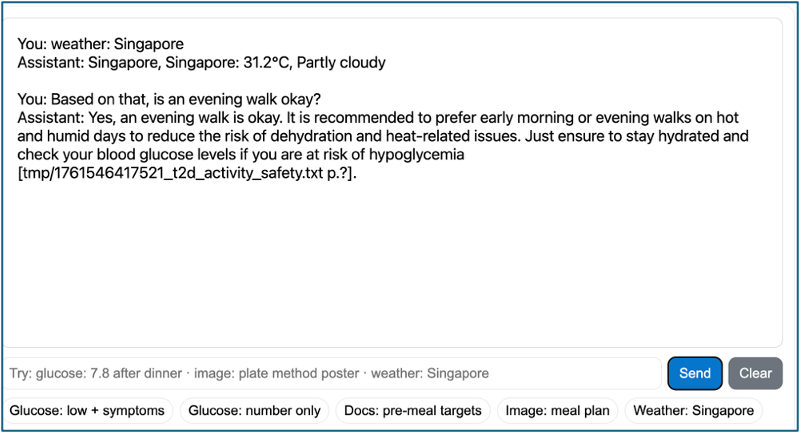

## Glucose Triage Demo (Educational)

In [ ]:
payload = {"message": "glucose: 3.2 mmol/L before breakfast shaky"}
res = requests.post(f"{BASE}/chat", json=payload).json()
print(res.get("reply", res))

## Multi-Agent Coordination via Controller

### Implementation Summary
- A lightweight controller (router) classifies each incoming message and dispatches it to the correct agent:
  - RAG Agent (default) — answers from uploaded docs with citations.
  - Weather Agent — current conditions via WeatherAPI.com.
  - SQL Agent — read-only queries against an in-memory clinic catalog.
  - Recommender Agent — content-based item suggestions using MiniLM embeddings.
  - T2I Agent — text-to-image generation via Replicate.
  - Glucose Triage Agent — non-diagnostic red/amber/green safety guidance.

- The controller also supplies a short memory window (last MAX_TURNS) so agents can maintain context.


1. The controller routes the first part to Recommender and the weather fragment to Weather, then composes a coherent response.
2.	RAG + Image generation:
The RAG agent provides grounded content; the T2I agent produces a shareable visual.


## 1.Weather + Recommender (Batch Prompt)

In [ ]:
payload = {"message": "weather: Singapore; recommend breathable walking shoes"}
res = requests.post(f"{BASE}/chat", json=payload).json()
print(res.get("reply", res))

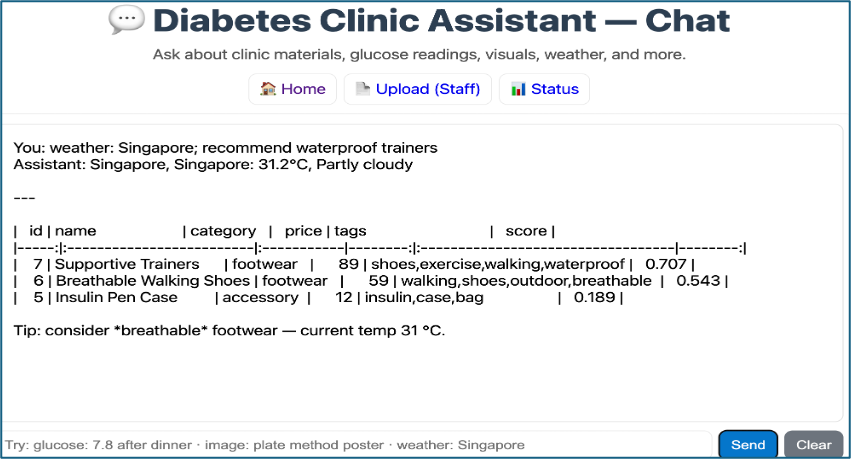

## SQL Demo (Read-only)

In [ ]:
payload = {"message": "sql: SELECT name, price FROM products WHERE category='device'"}
res = requests.post(f"{BASE}/chat", json=payload).json()
print(res.get("reply", res))

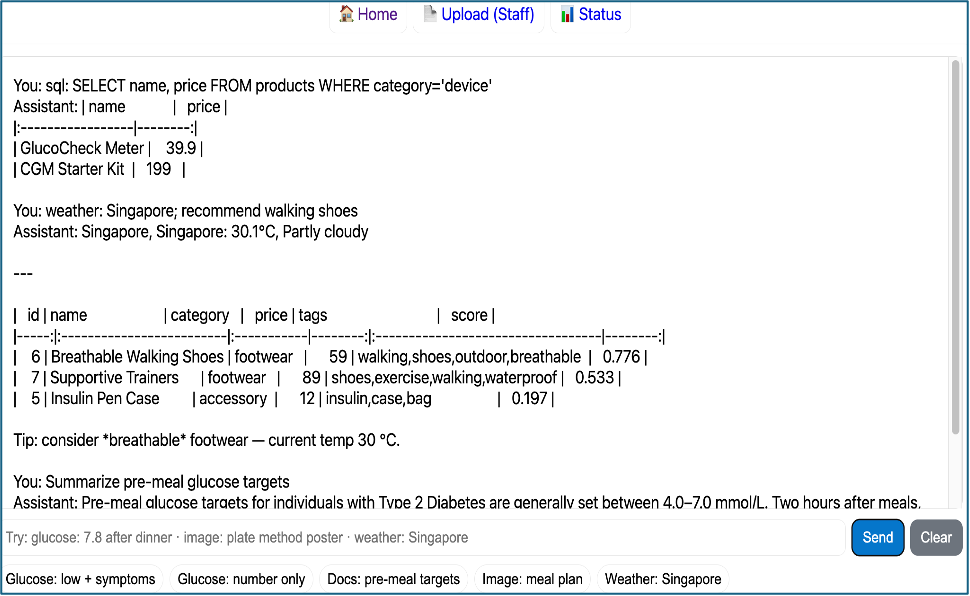

## 2.	RAG + Image generation:

## Image Generation with Prompt Engineering



### Implementation Summary
- Users can generate images by sending a prompt that starts with image: (or phrases like “generate an image” / “create an image”).

- The app uses Replicate (model: black-forest-labs/flux-dev) by default, and renders images inline in the chat UI.

- A dedicated debug route helps validate token setup and basic generation.


## Image Generation Demo (Replicate)

In [ ]:
payload = {"message": "image: plate method infographic for type 2 diabetes, A4 portrait"}
res = requests.post(f"{BASE}/chat", json=payload).json()
print(res.get("reply", res))

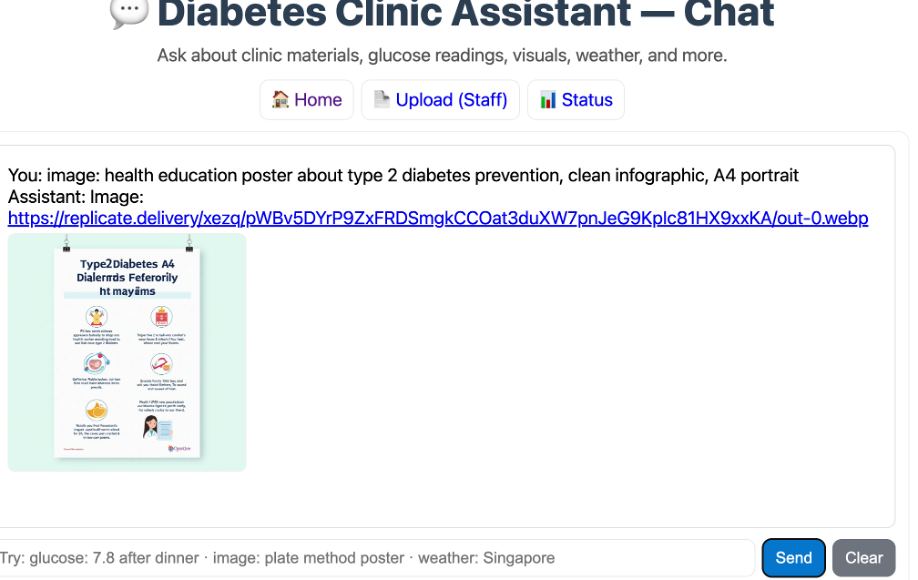

The RAG agent provides grounded content; the T2I agent produces a shareable visual.

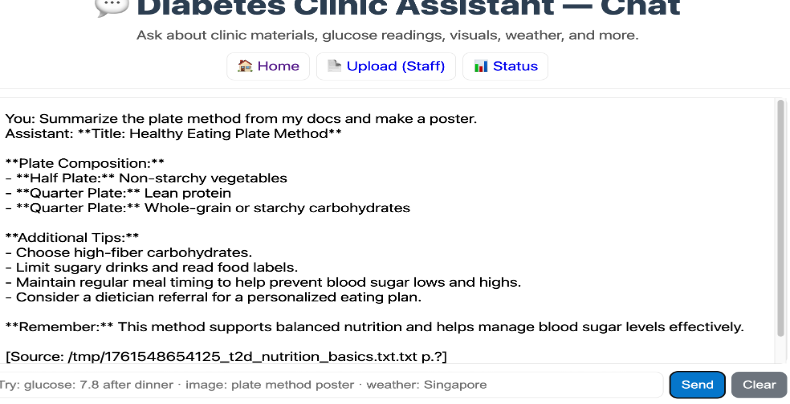

## Troubleshooting

- **OpenAI errors** → Check `OPENAI_API_KEY` and `OPENAI_MODEL` in my environment; confirm the server has access.
- **Upload fails** → `pip install python-multipart`.
- **SQLite thread error** → Use `check_same_thread=False` and a global `DB_LOCK` around DB access.
- **Images fail** → Set `REPLICATE_API_TOKEN`; test `/debug/replicate/run`.
- **Vector index not updating** → Ensure my PDFs/TXTs are text-based (not image-only). Use `/debug/status` to verify the collection.
- **CORS/local access** → Confirm the app is running with correct host/port and my browser is pointing to that address.